In [ ]:
from openai import OpenAI
import os
import base64
from IPython.display import Image as NotebookImage, display
from dotenv import load_dotenv
from json_repair import repair_json, loads

load_dotenv()

True

In [61]:
from PIL import Image, ImageDraw
import io


def draw_rectangle_on_image_bytes(image_bytes, rect_coords, color, width=1, output_format="PNG"):
    """
    在字节形式的图片数据上绘制一个矩形，并返回修改后的图片字节数据。

    Args:
        image_bytes (bytes): 输入图像的字节数据。
        rect_coords (tuple): 矩形的坐标，格式为 (x1, y1, x2, y2)，其中 (x1, y1) 是左上角坐标，(x2, y2) 是右下角坐标。
        color (str or tuple): 矩形的颜色，可以是颜色名称（如 'red'）或 RGB 元组（如 (255, 0, 0)）。
        width (int): 矩形边框的宽度（默认为 1）。
        output_format (str): 输出图片字节数据的格式，例如 "PNG", "JPEG" 等。

    Returns:
        bytes: 绘制矩形后的图片字节数据，如果操作失败则返回 None。
    """
    try:
        # 从字节数据加载图像
        # 使用 io.BytesIO 将字节数据包装成一个文件对象
        img_stream = io.BytesIO(image_bytes)
        img = Image.open(img_stream).convert("RGB") # 确保图像是 RGB 模式

        # 创建一个 ImageDraw 对象，用于在图像上绘图
        draw = ImageDraw.Draw(img)

        # 绘制矩形
        draw.rectangle(rect_coords, outline=color, width=width)

        # 将修改后的图像保存到字节流中
        output_stream = io.BytesIO()
        img.save(output_stream, format=output_format)
        output_stream.seek(0) # 将流的指针移到开头
        return output_stream.getvalue() # 获取字节数据

    except Exception as e:
        print(f"在字节数据上绘制矩形失败: {e}")
        return None
    
def get_image_dimensions_from_bytes(image_bytes):
    """
    从字节形式的图片数据中获取图像的宽度和高度。

    Args:
        image_bytes (bytes): 输入图像的字节数据。

    Returns:
        tuple: 包含图像宽度和高度的元组 (width, height)，如果无法读取图像或发生错误，则返回 None。
    """
    try:
        # 使用 io.BytesIO 将字节数据包装成一个文件对象
        img_stream = io.BytesIO(image_bytes)
        
        # 从字节流中打开图像
        img = Image.open(img_stream)
        
        # 获取图像的尺寸 (width, height)
        width, height = img.size
        
        return (width, height)
    except Exception as e:
        print(f"从字节数据读取图像尺寸失败: {e}")
        return None
    
def resize_image_from_bytes(image_bytes, target_size, output_format="PNG", resample_filter=Image.LANCZOS):
    """
    从字节形式的图片数据中加载图像，将其缩小到指定尺寸，并返回修改后的图片字节数据。

    Args:
        image_bytes (bytes): 输入图像的字节数据。
        target_size (tuple): 目标尺寸，格式为 (width, height)。
        output_format (str): 输出图片字节数据的格式，例如 "PNG", "JPEG" 等。
        resample_filter: 重采样滤波器。常用的有 Image.NEAREST, Image.BILINEAR,
                         Image.BICUBIC, Image.LANCZOS (推荐用于高质量缩放)。

    Returns:
        bytes: 缩小后的图片字节数据，如果操作失败则返回 None。
    """
    try:
        # 从字节数据加载图像
        img_stream = io.BytesIO(image_bytes)
        img = Image.open(img_stream)

        # 缩小图像到指定尺寸
        # Image.LANCZOS 是一个高质量的重采样滤波器，适合缩小图像
        resized_img = img.resize(target_size, resample=resample_filter)

        # 将修改后的图像保存到字节流中
        output_stream = io.BytesIO()
        resized_img.save(output_stream, format=output_format)
        output_stream.seek(0) # 将流的指针移到开头
        return output_stream.getvalue() # 获取字节数据

    except Exception as e:
        print(f"缩小图片失败: {e}")
        return None

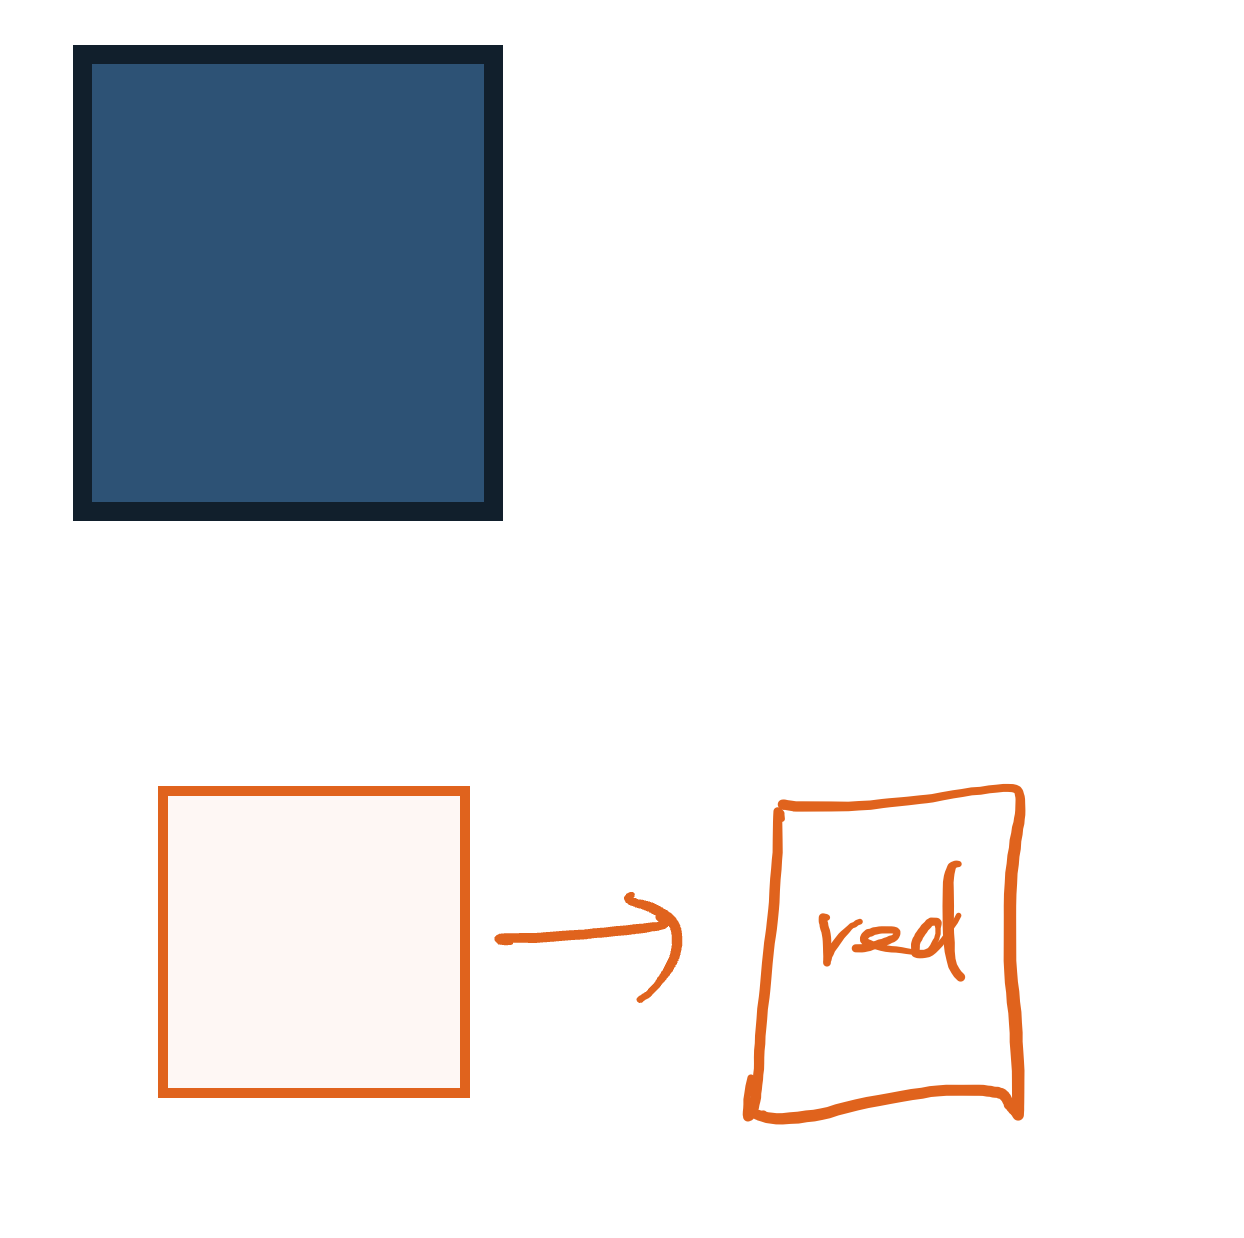

In [74]:
# load and show image
with open('./images/1.png', 'b+r') as f:
    image_data = f.read()
display(NotebookImage(data=image_data))

In [75]:
# openai client
API_BASE = "https://openrouter.ai/api/v1"
MODEL_NAME = 'anthropic/claude-sonnet-4'
client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'), base_url=API_BASE)
SCALED_SIZE = 256
small_image_data = resize_image_from_bytes(image_data, (SCALED_SIZE, SCALED_SIZE))
base64_image_data = base64.b64encode(small_image_data).decode('utf-8')
# send image to openai
prompt_text = """
这张图片是一个手绘的动画示例。其中包括需要动画的元素，以及手绘的描述动画过程的草图。
现在，请你返回一个数组，数组的每个元素是一个JSON格式对象，它包括4个字段，表示单个元素动画。如果动画涉及多个元素，你需要给每个元素返回一个对象。
1. target：表示动画目标元素的位置。它是一个对象，包括x,y，即包围盒的左上角位置，以及width和height，即包围盒的宽高。所有单位是像素大小。
2. toStyle：表示动画的目标样式。它是一个CSS对象，包括动画的目标样式。
3. description：用自然语言描述的动画过程。
4. originalSize：表示图片的原始尺寸，它是一个对象，包括width和height，是你看到的图片的像素大小。
你的回复必须是一个纯的JSON字符串，不带有任何其他内容。
当前图片的大小是：
""" + str(get_image_dimensions_from_bytes(small_image_data))
response = client.chat.completions.create(
    model=MODEL_NAME,
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt_text},
                {
                    "type": "image_url",
                            "image_url": {
                                "url": f"data:image/png;base64,{base64_image_data}",
                                "detail": "low",  # 可以是 "low", "high", 或 "auto"
                            },
                },
            ],
        }
    ],
)


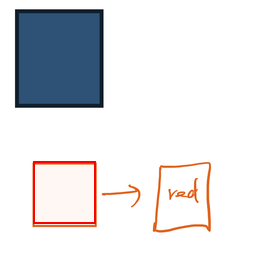

In [ ]:
res = loads(response.choices[0].message.content)

draw_img_data = small_image_data
for item in res:
    draw_img_data = draw_rectangle_on_image_bytes(draw_img_data, (
        item['target']['x'] / item['originalSize']['width'] * SCALED_SIZE,
        item['target']['y'] / item['originalSize']['height'] * SCALED_SIZE,
        item['target']['x'] / item['originalSize']['width'] * SCALED_SIZE  + item['target']['width'] / item['originalSize']['width'] * SCALED_SIZE,
        item['target']['y'] / item['originalSize']['height'] * SCALED_SIZE   + item['target']['height'] / item['originalSize']['height'] * SCALED_SIZE
    ), color='red', width=2)
display(Image.open(io.BytesIO(draw_img_data)))

In [77]:
res

[{'target': {'x': 33, 'y': 161, 'width': 62, 'height': 62},
  'toStyle': {'backgroundColor': '#ff6b35', 'border': '2px solid #ff6b35'},
  'description': '方形从浅色变为红色',
  'originalSize': {'width': 256, 'height': 256}}]